# Assessment of Tree Detection, Classification, and Geolocation Model
# Density Experiment - Match Predicted Trees to Tree Inventories and Compute RMSE Between Matches

Thomas Lake & Brit Laginhas, December 2024


In [1]:
# Imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

# Geospatial Analysis
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point, box
from shapely.ops import nearest_points

# Spatial Analysis
from scipy.spatial import cKDTree
from scipy import stats
from scipy.optimize import curve_fit, OptimizeWarning

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import contextily as ctx
import cartopy.crs as ccrs

# Statistical Analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import mean_squared_error

# Logging and Warnings
import logging
import warnings

# Configure Matplotlib
%matplotlib inline


# Experiments with Greedy Genus Matching Tree Inventories and Predictions

# Analysis of Greedy Genus Matching Between Tree Inventory and Tree Predictions

### Read in results of greedy matching across all cities


In [25]:
df = pd.read_csv(r'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/datasheets/all_cities_tree_greedy_genus_matching_results_dec524.csv')
city = "All_Cities"
# Rename City Column to All_Cities
df.rename(columns={"City": "All_Cities"}, inplace=True)

### Does Matching Tree Inventory to Predictions Depend on Number of Panoramic Images in a Grid?


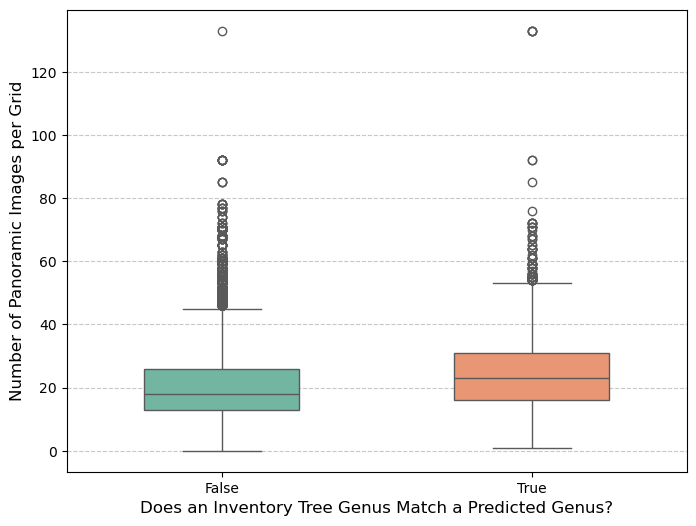

In [26]:
# Create boxplots for 'is_matched' versus 'grid_num_panos'
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_matched', y='grid_num_panos', data=df, palette="Set2", width=0.5, hue='is_matched')
plt.legend([], [], frameon=False)  # Hide legend if not needed

# Customize the plot
plt.xlabel("Does an Inventory Tree Genus Match a Predicted Genus?", fontsize=12)
plt.ylabel("Number of Panoramic Images per Grid", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_boxplots_num_panos_binary_greedy_match.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### Two-Sample t-test to compare means of two groups

In [27]:
# Average number of panoramic images for matching
mean_values = df.groupby('is_matched')['grid_num_panos'].mean()
print(mean_values)

# Count records for each category in 'is_matched'
counts = df['is_matched'].value_counts()
print(counts)

# Separate the data based on 'is_matched' values
matched_data = df[df['is_matched'] == True]['grid_num_panos']
unmatched_data = df[df['is_matched'] == False]['grid_num_panos']

is_matched
False    20.202034
True     24.668548
Name: grid_num_panos, dtype: float64
is_matched
False    35494
True      4076
Name: count, dtype: int64


In [28]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*scipy.stats.shapiro.*")

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(matched_data, unmatched_data)

# Display the results
print(f"T-statistic: {t_stat:.6f}")
print(f"P-value: {p_value:.6f}")

# Perform the Shapiro-Wilk test for normality - the data are not normally distributed
_, p_normal_matched = stats.shapiro(matched_data)
_, p_normal_unmatched = stats.shapiro(unmatched_data)

# Display the results
print(f"Shapiro-Wilk test for normality (Matched): p-value = {p_normal_matched:.3f}")
print(f"Shapiro-Wilk test for normality (Unmatched): p-value = {p_normal_unmatched:.3f}")

# If the data is not normally distributed, use the Mann-Whitney U test
u_stat, p_value_u = stats.mannwhitneyu(matched_data, unmatched_data)

# Display the result
print(f"U-statistic: {u_stat:.6f}")
print(f"P-value: {p_value_u:.6f}")

T-statistic: 25.711276
P-value: 0.000000
Shapiro-Wilk test for normality (Matched): p-value = 0.000
Shapiro-Wilk test for normality (Unmatched): p-value = 0.000
U-statistic: 89760838.500000
P-value: 0.000000


### Summary histograms: Number of Inventory Trees Per Grid, Number of Panos Per Grid, Proportion of Inventory Trees Matching Predictions, Min. Dist. to Nearest Neighbor,

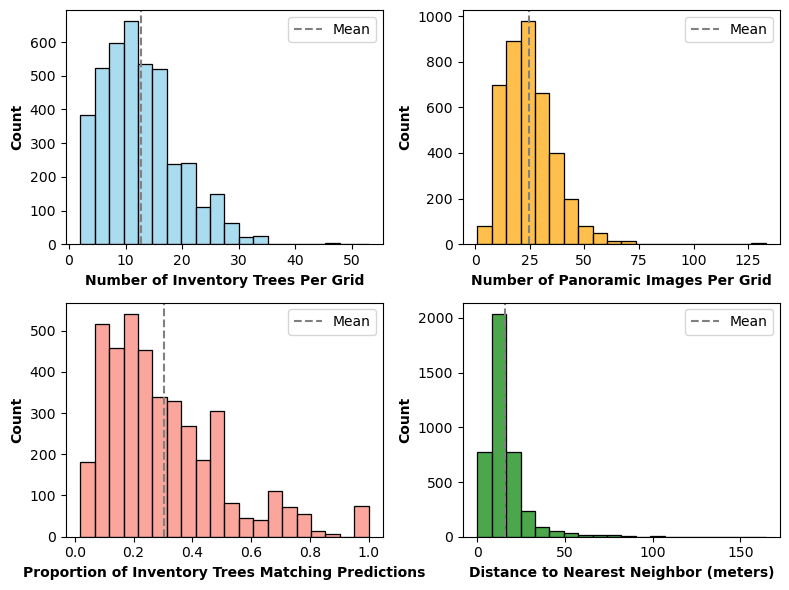

In [29]:
# Remove NA cases with no matches for plotting
df = df.replace([float('inf'), -float('inf')], pd.NA).dropna()

# Create a figure to contain the histograms
plt.figure(figsize=(8, 6))

# Plot histograms for each of the variables
# 1. Number of Inventory Trees
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='num_inv_trees', kde=False, color='skyblue', bins=20, alpha=0.7)
plt.axvline(df['num_inv_trees'].mean(), color="grey", linestyle='--', label='Mean')
plt.xlabel('Number of Inventory Trees Per Grid', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.legend()

# 2. Number of Panoramic Images
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='grid_num_panos', kde=False, color='orange', bins=20, alpha=0.7)
plt.axvline(df['grid_num_panos'].mean(), color="grey", linestyle='--', label='Mean')
plt.xlabel('Number of Panoramic Images Per Grid', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.legend()

# 3. Proportion of Inventory Trees Matching Predictions
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='proportion_matches', kde=False, color='salmon', bins=20, alpha=0.7)
plt.axvline(df['proportion_matches'].mean(), color="grey", linestyle='--', label='Mean')
plt.xlabel('Proportion of Inventory Trees Matching Predictions', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.legend()

# 4. Distance to Nearest Neighbor
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='min_nn_distance', kde=False, color='green', bins=20, alpha=0.7)
plt.axvline(df['min_nn_distance'].mean(), color="grey", linestyle='--', label='Mean')
plt.xlabel('Distance to Nearest Neighbor (meters)', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure to the specified path
output_path = f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_histograms_trees_panos_matches_distances.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

# Show the plots
plt.show()

### Boxplot: Number of Inventory Trees vs. Grid Density Level; Note: removed outlier to improve visualization

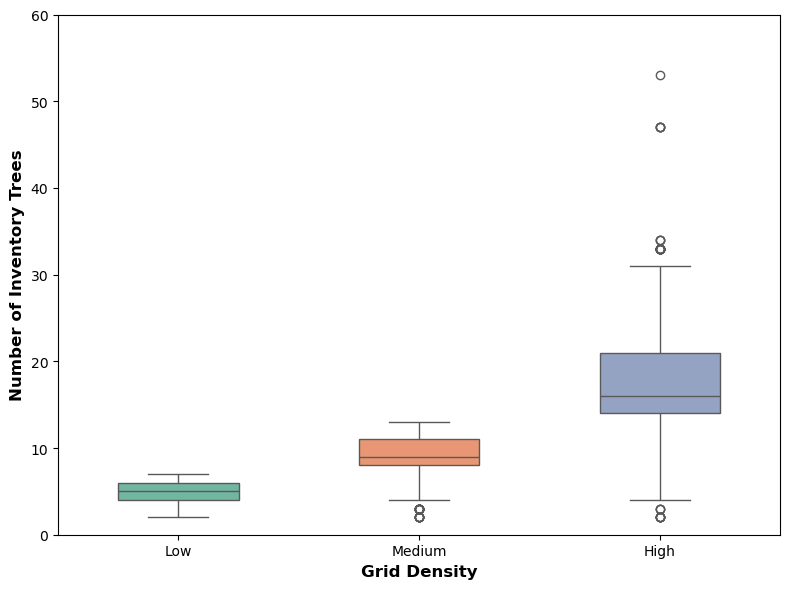

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='grid_density_level', y='num_inv_trees', hue='grid_density_level', palette='Set2', width=0.5, legend=False)

# Add labels
plt.xlabel('Grid Density', fontsize=12, fontweight='bold')
plt.ylabel('Number of Inventory Trees', fontsize=12, fontweight='bold')
plt.ylim(0, 60)  # Set y-axis limit

# Change x category labels
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_boxplots_num_inv_trees_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

### Boxplots - Relationship between Inventory Tree Density and Proportion of Matches by Genus


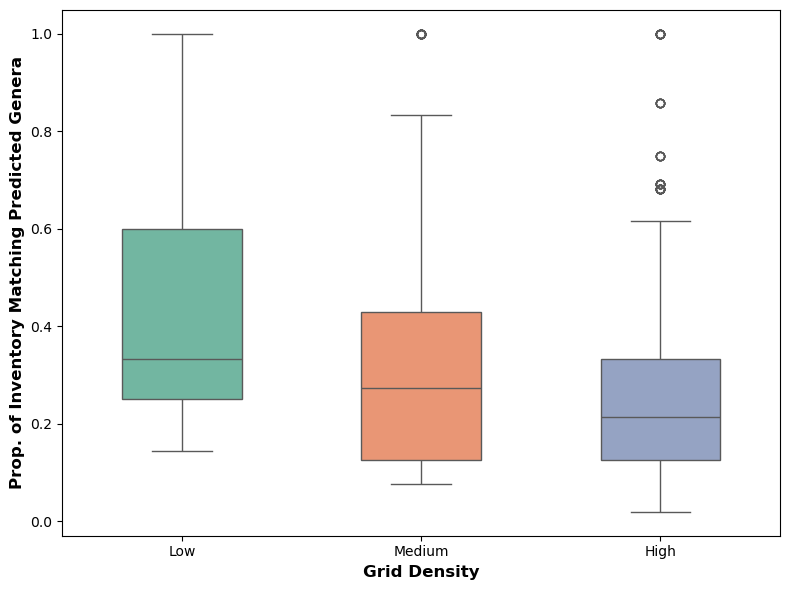

In [31]:
###
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='grid_density_level', y='proportion_matches', hue='grid_density_level', palette='Set2', width=0.5, legend=False)

# Add titles and labels
plt.xlabel('Grid Density', fontsize=12, fontweight='bold')
plt.ylabel('Prop. of Inventory Matching Predicted Genera', fontsize=12, fontweight='bold')

# Change x category labels
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_boxplots_proportion_matches_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

### Perform One-Way ANOVA based on Grid Density Level

In [32]:
# Separate the data based on 'grid_density_level'
low_density = df[df['grid_density_level'] == 'Low Density']['proportion_matches']
med_density = df[df['grid_density_level'] == 'Medium Density']['proportion_matches']
high_density = df[df['grid_density_level'] == 'High Density']['proportion_matches']

# Perform One-Way ANOVA
f_stat, p_value = stats.f_oneway(low_density, med_density, high_density)

# Display the results
print(f"F-statistic: {f_stat:.6f}")
print(f"P-value: {p_value:.6f}")

F-statistic: 261.985813
P-value: 0.000000


In [33]:
# Perform Shapiro-Wilk test for normality in each group
_, p_normal_low = stats.shapiro(low_density)
_, p_normal_med = stats.shapiro(med_density)
_, p_normal_high = stats.shapiro(high_density)

# Display normality results
print(f"Shapiro-Wilk test for normality (Low Density): p-value = {p_normal_low:.3f}")
print(f"Shapiro-Wilk test for normality (Medium Density): p-value = {p_normal_med:.3f}")
print(f"Shapiro-Wilk test for normality (High Density): p-value = {p_normal_high:.3f}")

# If data is not normal, use the Kruskal-Wallis test
h_stat, p_value_h = stats.kruskal(low_density, med_density, high_density)

# Display the result
print(f"H-statistic: {h_stat:.3f}")
print(f"P-value: {p_value_h:.3f}")

# Fit an ANOVA model
model = ols('proportion_matches ~ grid_density_level', data=df).fit()

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['proportion_matches'], groups=df['grid_density_level'], alpha=0.05)

# Display the results
print(tukey.summary())


Shapiro-Wilk test for normality (Low Density): p-value = 0.000
Shapiro-Wilk test for normality (Medium Density): p-value = 0.000
Shapiro-Wilk test for normality (High Density): p-value = 0.000
H-statistic: 411.183
P-value: 0.000
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
High Density    Low Density   0.1902   0.0  0.1704  0.2101   True
High Density Medium Density   0.0751   0.0  0.0591  0.0911   True
 Low Density Medium Density  -0.1152   0.0 -0.1365 -0.0939   True
-----------------------------------------------------------------


### Boxplots - Relationship between Inventory Tree Density and Proportion of Matches by Genus

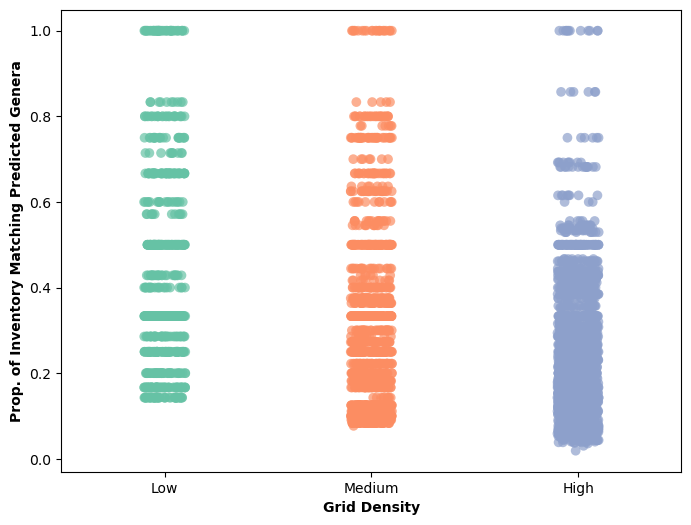

In [34]:
plt.figure(figsize=(8, 6))

# Assign the x variable to hue to avoid the warning
sns.stripplot(
    x='grid_density_level', 
    y='proportion_matches', 
    data=df, 
    palette="Set2", 
    jitter=True, 
    alpha=0.7, 
    size=7, 
    hue='grid_density_level'  # Assign hue to match x
)
plt.legend([], [], frameon=False)  # Hide legend if not needed

# Customize the plot
plt.xlabel("Grid Density", fontsize=10, fontweight='bold')
plt.ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])


# Save the plot
output_path = f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_stripplots_proportion_matches_by_grid_density.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

plt.show()

### Boxplots - Relationship between Grid Density and Num. Panos per Grid

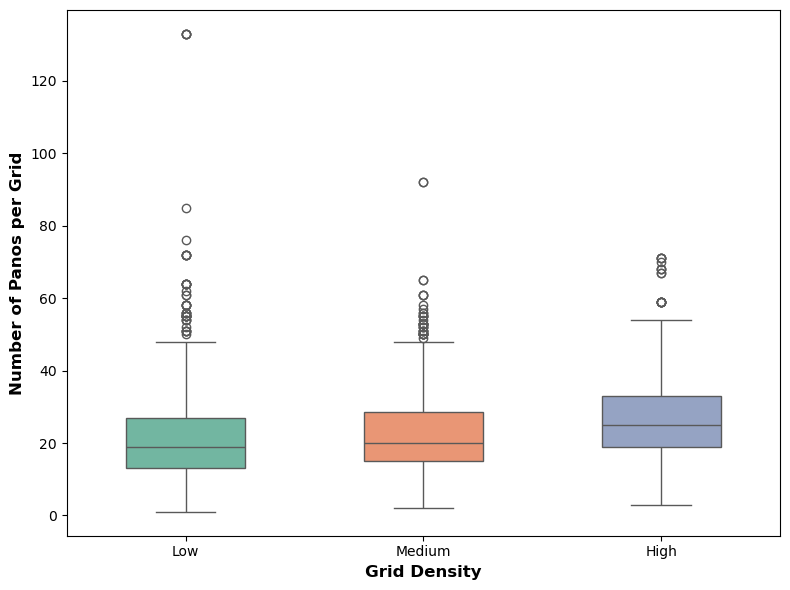

In [35]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='grid_density_level', y='grid_num_panos', hue='grid_density_level', palette='Set2', width=0.5, legend=False)

# Add titles and labels
plt.xlabel('Grid Density', fontsize=12, fontweight='bold')
plt.ylabel('Number of Panos per Grid', fontsize=12, fontweight='bold')

# Change x category labels
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_boxplots_num_panos_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

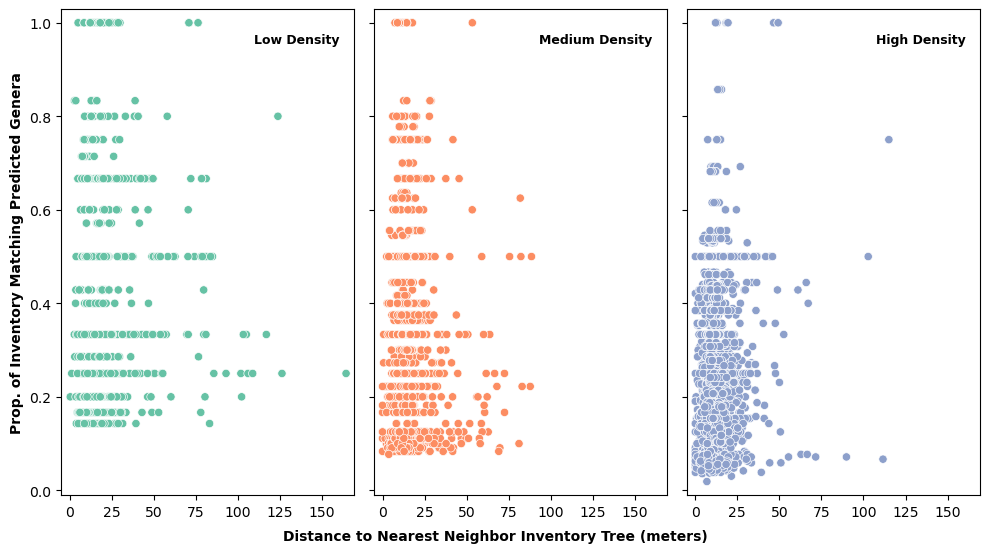

In [36]:
# Unique density levels in the dataset
density_levels = df['grid_density_level'].unique()

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharex=True, sharey=True)

# Define the color palette for consistency
palette = sns.color_palette("Set2", len(density_levels))

# Iterate through each density level and plot on separate subplots
for i, density in enumerate(density_levels):
  # Filter data for the current density level
  subset_df = df[df['grid_density_level'] == density]
  
  # Create the scatterplot
  sns.scatterplot(
    x='min_nn_distance', 
    y='proportion_matches', 
    data=subset_df, 
    hue='grid_density_level', 
    palette={density: palette[i]},  # Maintain the same color for each density
    ax=axes[i],
    legend=False  # Remove legend for individual plots
  )
  
  # Set the title for each subplot
  axes[i].set_ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')
  
  # Add the density label in the top right corner within each plot
  axes[i].text(
    0.95, 0.95, density, 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=axes[i].transAxes, 
    fontsize=9, 
    fontweight='bold',  # Make the density label bold
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
  )

# Set the same x and y axis limits for all subplots with buffer
x_min, x_max = df['min_nn_distance'].min(), df['min_nn_distance'].max()
y_min, y_max = df['proportion_matches'].min(), df['proportion_matches'].max()
x_buffer = (x_max - x_min) * 0.03
y_buffer = (y_max - y_min) * 0.03
for ax in axes:
  ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
  ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
  ax.set_xlabel("", fontsize=14, fontweight='bold')  # Remove x-axis label

# Add a single x-axis label for the entire figure
fig.text(0.5, 0.04, "Distance to Nearest Neighbor Inventory Tree (meters)", ha='center', fontsize=10, fontweight='bold')

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust the rect parameter to make space for the x-axis label

# Save the figure
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_scatterplot_proportion_matches_by_nearest_neighbor_density_comparison.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()

### Boxplots - Relationship between Inventory Nearest Neighbor Distance and Proportion of Matches by Grid


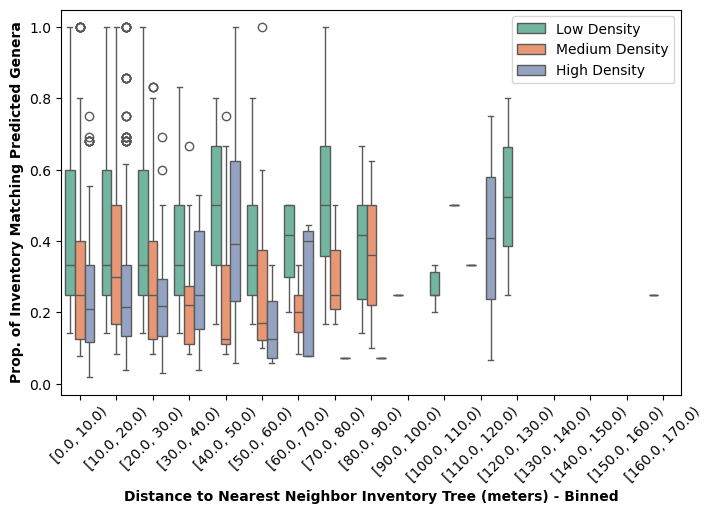

In [37]:
# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['min_nn_distance_bin'] = pd.cut(df['min_nn_distance'], bins=np.arange(0, df['min_nn_distance'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(8, 5))
sns.boxplot(x='min_nn_distance_bin', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters) - Binned", fontsize=10, fontweight='bold')
plt.ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')

plt.xticks(rotation=45)

# Remove the "grid_density_level" from the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(density_levels)], labels[:len(density_levels)], title='')

plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_boxplots_proportion_matches_by_nearest_neighbor_density_categories.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

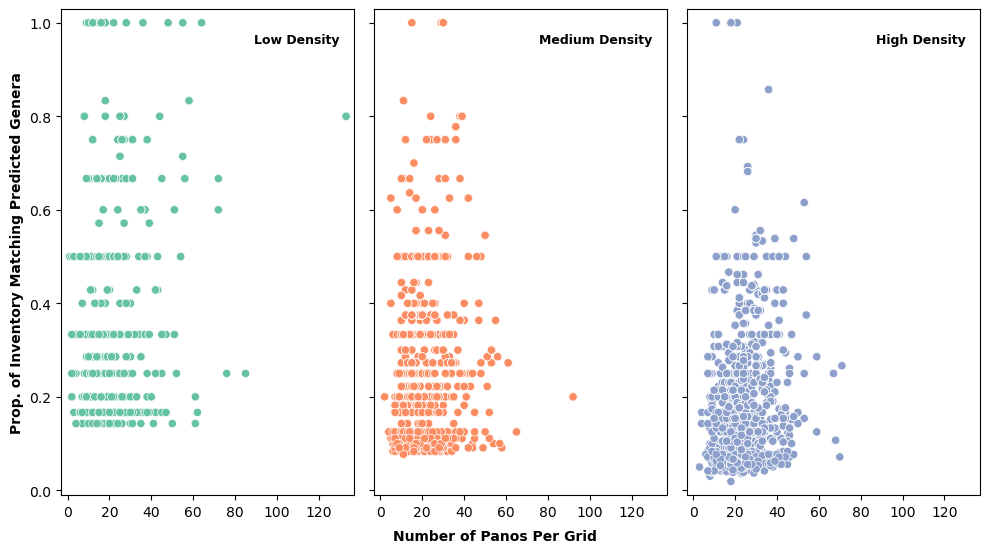

In [38]:
# Unique density levels in the dataset
density_levels = df['grid_density_level'].unique()

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharex=True, sharey=True)

# Define the color palette for consistency
palette = sns.color_palette("Set2", len(density_levels))

# Iterate through each density level and plot on separate subplots
for i, density in enumerate(density_levels):
  # Filter data for the current density level
  subset_df = df[df['grid_density_level'] == density]
  
  # Create the scatterplot
  sns.scatterplot(
    x='grid_num_panos', 
    y='proportion_matches', 
    data=subset_df, 
    hue='grid_density_level', 
    palette={density: palette[i]},  # Maintain the same color for each density
    ax=axes[i],
    legend=False  # Remove legend for individual plots
  )
  
  # Set the title for each subplot
  axes[i].set_ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')
  
  # Add the density label in the top right corner within each plot
  axes[i].text(
    0.95, 0.95, density, 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=axes[i].transAxes, 
    fontsize=9, 
    fontweight='bold',  # Make the density label bold
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
  )

# Set the same x and y axis limits for all subplots with buffer
x_min, x_max = df['grid_num_panos'].min(), df['grid_num_panos'].max()
y_min, y_max = df['proportion_matches'].min(), df['proportion_matches'].max()
x_buffer = (x_max - x_min) * 0.03
y_buffer = (y_max - y_min) * 0.03
for ax in axes:
  ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
  ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
  ax.set_xlabel("", fontsize=14, fontweight='bold')  # Remove x-axis label

# Add a single x-axis label for the entire figure
fig.text(0.5, 0.04, "Number of Panos Per Grid", ha='center', fontsize=10, fontweight='bold')

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust the rect parameter to make space for the x-axis label

# Save the figure
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_scatterplot_proportion_matches_by_num_panos_density_comparison.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()

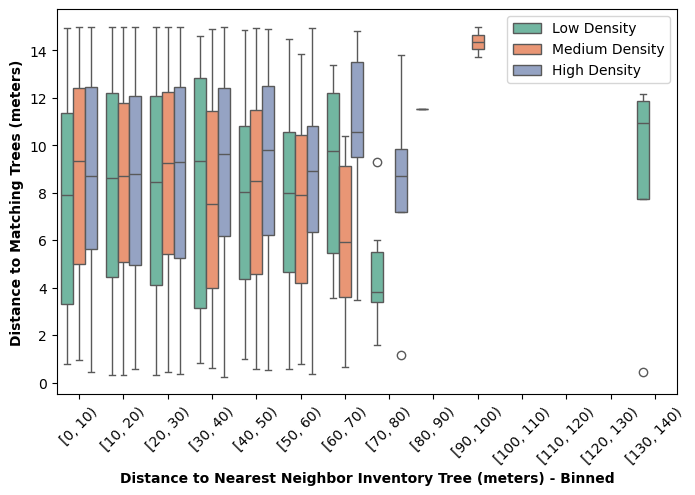

In [39]:
# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['grid_num_panos_bin'] = pd.cut(df['grid_num_panos'], bins=np.arange(0, df['grid_num_panos'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(8, 5))
sns.boxplot(x='grid_num_panos_bin', y='match_distance', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters) - Binned", fontsize=10, fontweight='bold')
plt.ylabel("Distance to Matching Trees (meters)", fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
# Remove the "grid_density_level" from the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(density_levels)], labels[:len(density_levels)], title='')
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_boxplots_distance matching_trees_by_nearest_neighbor_density_categories.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

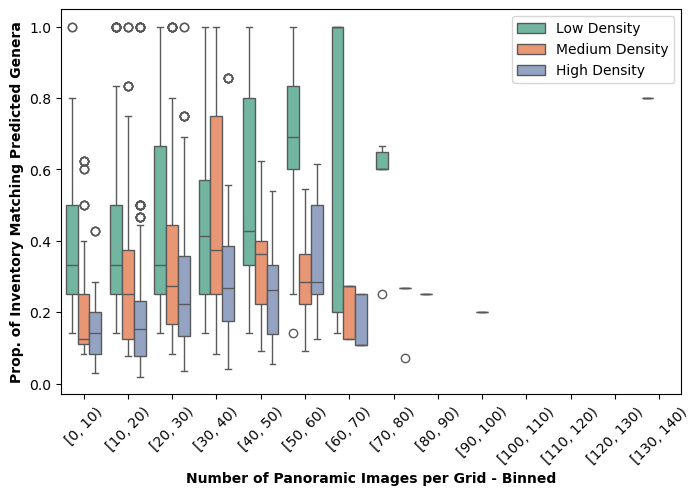

In [40]:
# Boxplots - Relationship between Num. Panos per Grid and Proportion of Matches by Genus

# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['grid_num_panos_bin'] = pd.cut(df['grid_num_panos'], bins=np.arange(0, df['grid_num_panos'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(8, 5))
sns.boxplot(x='grid_num_panos_bin', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Number of Panoramic Images per Grid - Binned", fontsize=10, fontweight='bold')
plt.ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')
plt.xticks(rotation=45)
# Remove the "grid_density_level" from the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(density_levels)], labels[:len(density_levels)], title='')
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/{city}_prop_trees matching_by_number_of_panoramic_images_grid.png', dpi=300, bbox_inches='tight', format='png')


plt.show()

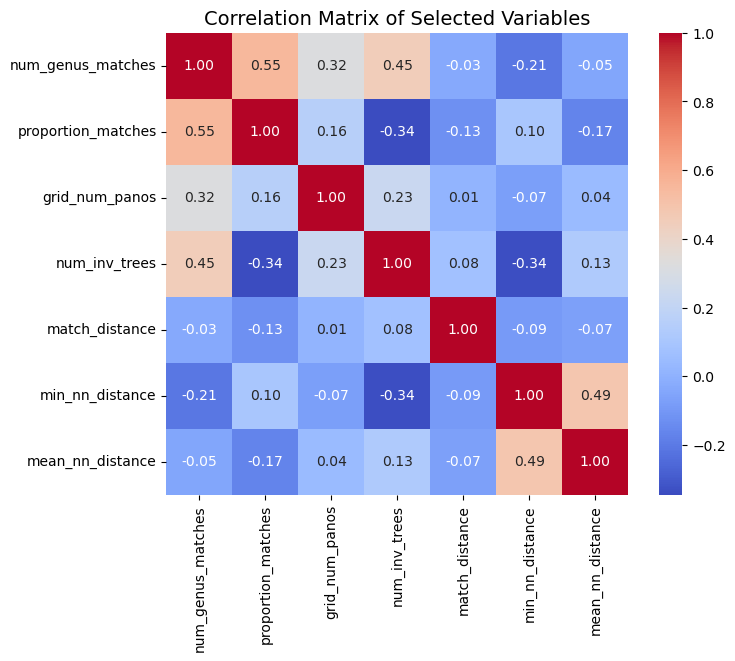

In [41]:
# Select only the specified numeric columns from the dataframe
selected_columns = ['num_genus_matches', 'proportion_matches', 'grid_num_panos', 'num_inv_trees', 'match_distance', 'min_nn_distance', 'mean_nn_distance']
numeric_df = df[selected_columns]

# Calculate the correlation matrix for the selected numeric variables
correlation_matrix = numeric_df.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)

# Customize the heatmap
plt.title("Correlation Matrix of Selected Variables", fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0)

plt.show()


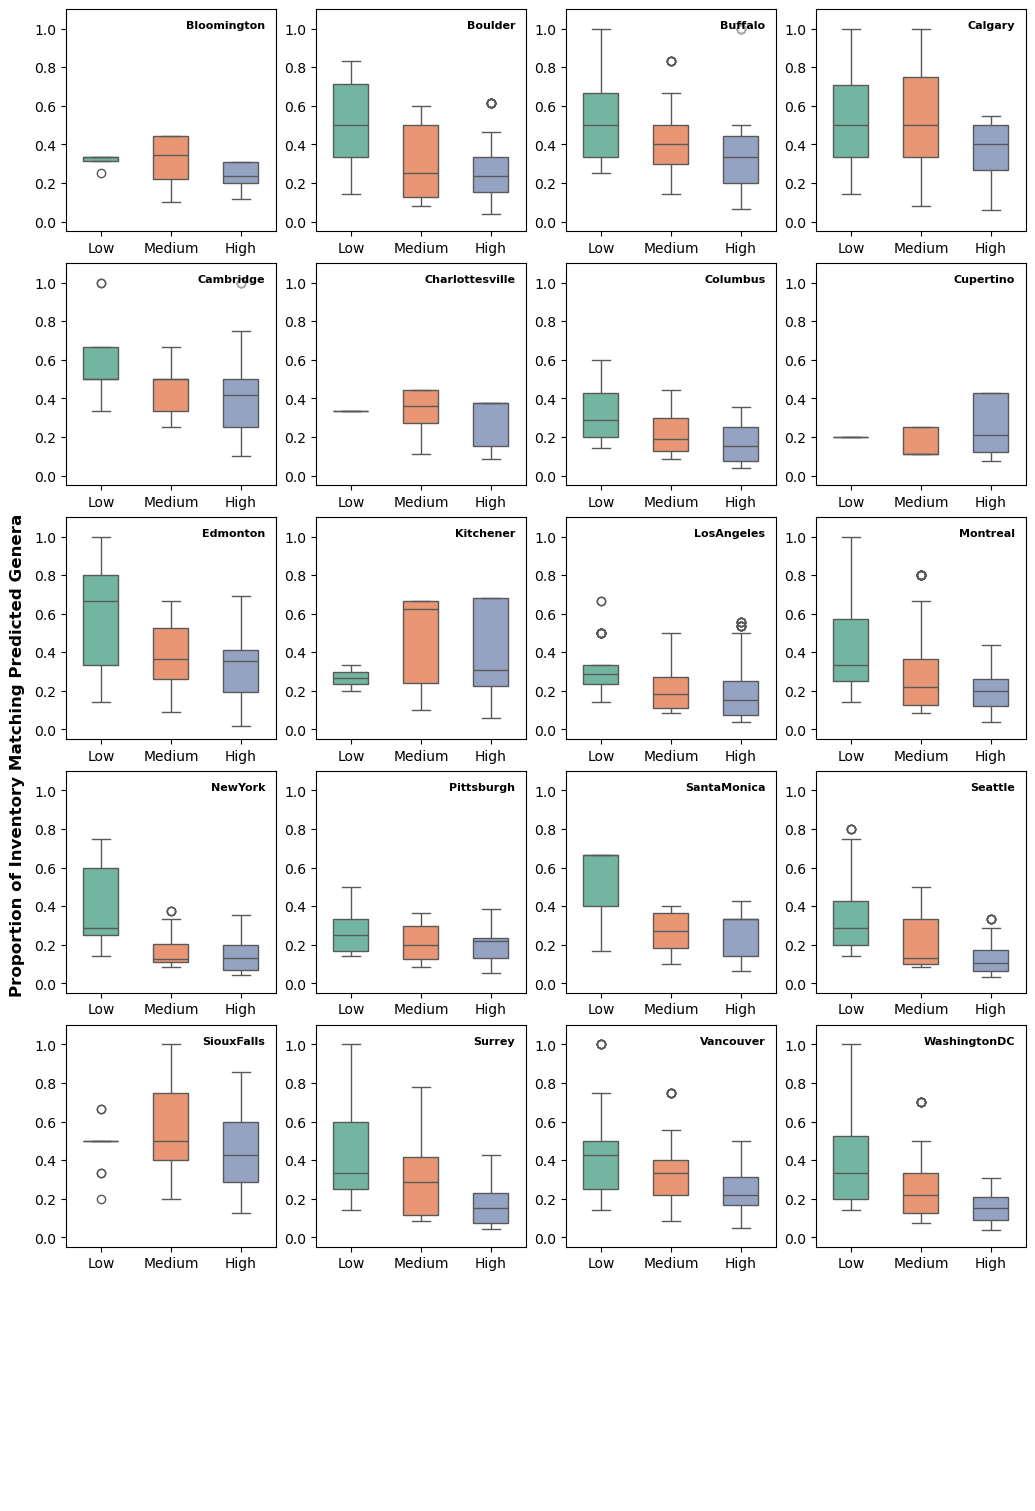

In [42]:
# Ensure unique cities are identified
unique_cities = np.sort(df['All_Cities'].unique())
num_cities = len(unique_cities)

# Set up the grid dimensions
rows = 6
cols = 4

# Calculate the figure size dynamically based on grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each city and create a boxplot
for i, city in enumerate(unique_cities):
  # Filter the DataFrame for the current city
  city_df = df[df['All_Cities'] == city]
  
  # Plot on the appropriate subplot
  sns.boxplot(
    x='grid_density_level', 
    y='proportion_matches', 
    hue='grid_density_level',
    data=city_df, 
    ax=axes[i], 
    palette="Set2", 
    width=0.5,
    legend=False
  )
  
  # Customize the subplot
  axes[i].set_xlabel("")
  axes[i].set_ylabel("")
  axes[i].set_xticks([0, 1, 2])  # Set the ticks first
  axes[i].set_xticklabels(["Low", "Medium", "High"])  # Update x labels
  axes[i].set_ylim(-0.05, 1.1)  # Set y-axis limits with a little buffer
  
  # Add the city name in the top right corner within each plot
  axes[i].text(
    0.95, 0.95, city, 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=axes[i].transAxes, 
    fontsize=8, 
    fontweight='bold',  # Make the city label bold
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
  )

# Turn off unused subplots
for j in range(len(unique_cities), len(axes)):
  axes[j].axis('off')

# Add a single y-axis label for all plots
fig.text(-0.02, 0.5, 'Proportion of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=12, fontweight='bold')

# Save the entire grid of plots
output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/per_city_boxplots_proportion_matches_by_grid_density.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()


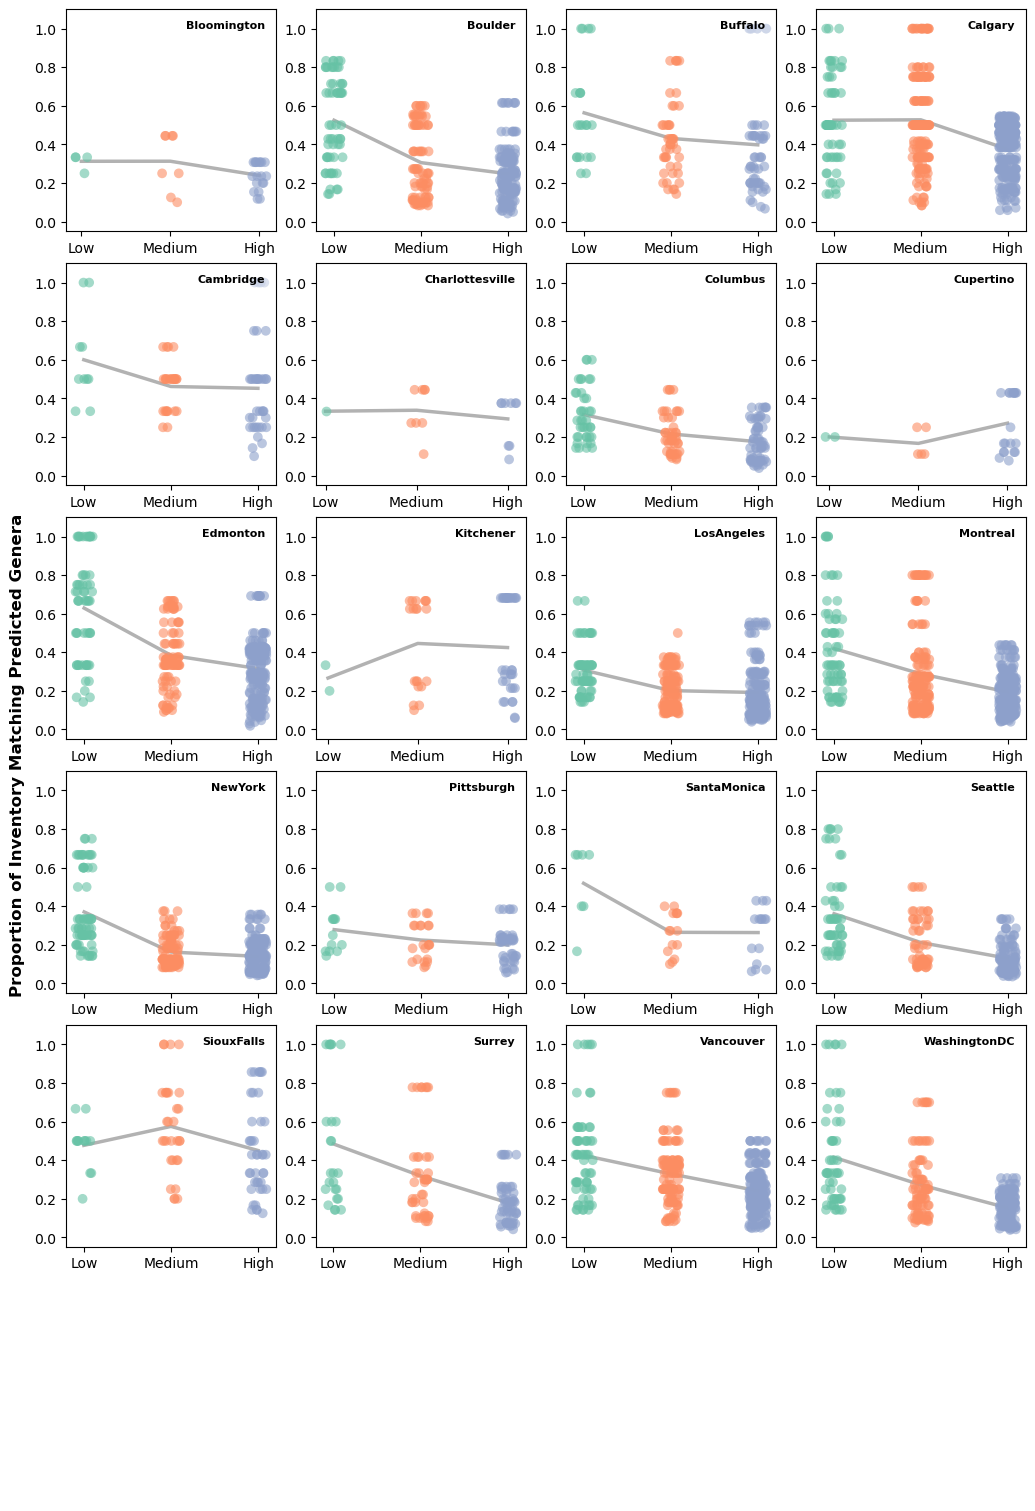

In [43]:
# Ensure unique cities are identified
unique_cities = np.sort(df['All_Cities'].unique())
num_cities = len(unique_cities)

# Set up the grid dimensions
rows = 6
cols = 4

# Calculate the figure size dynamically based on grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each city and create a jitter plot with a simple trend line
for i, city in enumerate(unique_cities):
    # Filter the DataFrame for the current city
    city_df = df[df['All_Cities'] == city]

    # Plot jitter points with partially transparent colors
    sns.stripplot(
        x='grid_density_level',
        y='proportion_matches',
        data=city_df,
        ax=axes[i],
        palette="Set2",
        jitter=True,
        alpha=0.6,  # Increase transparency
        size=7,
        hue='grid_density_level'
    )

    # Add a simple, thicker, and slightly transparent gray trend line
    sns.lineplot(
        x='grid_density_level',
        y='proportion_matches',
        data=city_df,
        ax=axes[i],
        color='gray',
        alpha=0.6,  # Slight transparency
        linewidth=2.5,  # Thicker line
        errorbar=None  # Suppress error bars to avoid warnings
    )
    
    # Customize the subplot
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([0, 1, 2])  # Set the ticks first
    axes[i].set_xticklabels(["Low", "Medium", "High"])  # Update x labels
    axes[i].set_ylim(-0.05, 1.1)  # Set y-axis limits with a little buffer
    
    # Add the city name in the top right corner within each plot
    axes[i].text(
        0.95, 0.95, city,
        horizontalalignment='right',
        verticalalignment='top',
        transform=axes[i].transAxes,
        fontsize=8,
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )
    
    # Hide the legend for individual subplots
    axes[i].legend([], [], frameon=False)

# Turn off unused subplots
for j in range(len(unique_cities), len(axes)):
    axes[j].axis('off')

# Add a single y-axis label for all plots
fig.text(-0.02, 0.5, 'Proportion of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=12, fontweight='bold')

# Save the entire grid of plots
output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/per_city_jitterplots_prop_matching_by_grid_density.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()


## XY Plots Prop. of Matches by Number of Inventory Trees 

## Define functions of hypothesized (inverse) relationship between x and y; find best fit overall and per city

In [44]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)

# Define decay functions
def negative_exponential(x, a, b, c):
    return a * np.exp(-b * np.clip(x, 0, 1e6)) + c

def linear_decay(x, k, b):
    return -k * x + b

def polynomial_decay(x, a, n):
    return a * x**n

def hyperbolic_decay(x, a, b):
    return a / (1 + b * np.clip(x, 0, 1e6))

def weibull_decay(x, a, b, c):
    return a * np.exp(-((x / b)**c))

def reciprocal_decay(x, a, b):
    return a / (np.clip(x, 0, 1e6) + b)

def linear_function(x, m, c):
    return m * x + c

# Add jitter to the data
df['jittered_x'] = df['num_inv_trees'] + np.random.uniform(0, 0, size=len(df))

# Define all functions with labels
functions = [
    (negative_exponential, "Negative Exponential"),
    (linear_decay, "Linear Decay"),
    #(logarithmic_decay, "Logarithmic Decay"),
    (polynomial_decay, "Polynomial Decay"),
    (hyperbolic_decay, "Hyperbolic Decay"),
    #(logistic_function, "Logistic Function"),
    #(gompertz_curve, "Gompertz Curve"),
    (weibull_decay, "Weibull Decay"),
    (reciprocal_decay, "Reciprocal Decay"),
    (linear_function, "Linear Function"),
]

# Overall trend line
overall_rmse_results = []
x_fit_overall = np.linspace(df['num_inv_trees'].min(), df['num_inv_trees'].max(), 200)

for func, label in functions:
    try:
        popt, _ = curve_fit(
            func,
            df['num_inv_trees'],
            df['proportion_matches'],
            maxfev=10000
        )
        y_pred = func(df['num_inv_trees'], *popt)
        rmse = np.sqrt(mean_squared_error(df['proportion_matches'], y_pred))
        overall_rmse_results.append((label, rmse, popt))
    except Exception:
        pass

# Sort and select the best overall fit
overall_rmse_results.sort(key=lambda x: x[1])
best_overall_fit = overall_rmse_results[0]
logger.info(f"Best Overall Fit: {best_overall_fit[0]} with RMSE = {best_overall_fit[1]:.4f}")

# City-specific trend lines
grouped = df.groupby('All_Cities')
city_results = {}

for city, group in grouped:
    city_rmse_results = []
    for func, label in functions:
        try:
            popt, _ = curve_fit(
                func,
                group['num_inv_trees'],
                group['proportion_matches'],
                maxfev=10000
            )
            y_pred = func(group['num_inv_trees'], *popt)
            rmse = np.sqrt(mean_squared_error(group['proportion_matches'], y_pred))
            city_rmse_results.append((label, rmse, popt))
        except Exception:
            pass
    
    # Sort and select the best fit for the city
    city_rmse_results.sort(key=lambda x: x[1])
    best_city_fit = city_rmse_results[0]
    logger.info(f"Best Fit for {city}: {best_city_fit[0]} with RMSE = {best_city_fit[1]:.4f}")
    city_results[city] = city_rmse_results

# Prepare results for export
results_list = []
best_results_list = []

# Add overall results
for result in overall_rmse_results:
    results_list.append({
        'Scope': 'Overall',
        'City': 'All',
        'Function': result[0],
        'RMSE': result[1],
        'Parameters': result[2]
    })

# Add city-specific results
for city, results in city_results.items():
    for result in results:
        results_list.append({
            'Scope': 'City',
            'City': city,
            'Function': result[0],
            'RMSE': result[1],
            'Parameters': result[2]
        })
    # Add best fit for each city
    best_fit = results[0]
    best_results_list.append({
        'Scope': 'City',
        'City': city,
        'Function': best_fit[0],
        'RMSE': best_fit[1],
        'Parameters': best_fit[2]
    })

# Add best overall result
best_results_list.append({
    'Scope': 'Overall',
    'City': 'All',
    'Function': best_overall_fit[0],
    'RMSE': best_overall_fit[1],
    'Parameters': best_overall_fit[2]
})

# Export all results to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv('/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/all_cities_all_rmse_prop_matches_num_inv_trees.csv', index=False)

# Export best results to CSV
best_results_df = pd.DataFrame(best_results_list)
best_results_df.to_csv('/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/all_cities_best_rmse_prop_matches_num_inv_trees.csv', index=False)

logger.info("All results saved to 'all_fitting_results.csv'.")
logger.info("Best results saved to 'best_fitting_results.csv'.")

Best Overall Fit: Negative Exponential with RMSE = 0.1855
Best Fit for Bloomington: Weibull Decay with RMSE = 0.0850
Best Fit for Boulder: Reciprocal Decay with RMSE = 0.1719
Best Fit for Buffalo: Negative Exponential with RMSE = 0.2313
Best Fit for Calgary: Weibull Decay with RMSE = 0.1918
Best Fit for Cambridge: Polynomial Decay with RMSE = 0.1803
Best Fit for Charlottesville: Polynomial Decay with RMSE = 0.1158
Best Fit for Columbus: Weibull Decay with RMSE = 0.1119
Best Fit for Cupertino: Weibull Decay with RMSE = 0.1333
Best Fit for Edmonton: Negative Exponential with RMSE = 0.1722
Best Fit for Kitchener: Hyperbolic Decay with RMSE = 0.1958
Best Fit for LosAngeles: Polynomial Decay with RMSE = 0.1151
Best Fit for Montreal: Negative Exponential with RMSE = 0.1756
Best Fit for NewYork: Negative Exponential with RMSE = 0.1070
Best Fit for Pittsburgh: Polynomial Decay with RMSE = 0.0926
Best Fit for SantaMonica: Polynomial Decay with RMSE = 0.1488
Best Fit for Seattle: Negative Expone

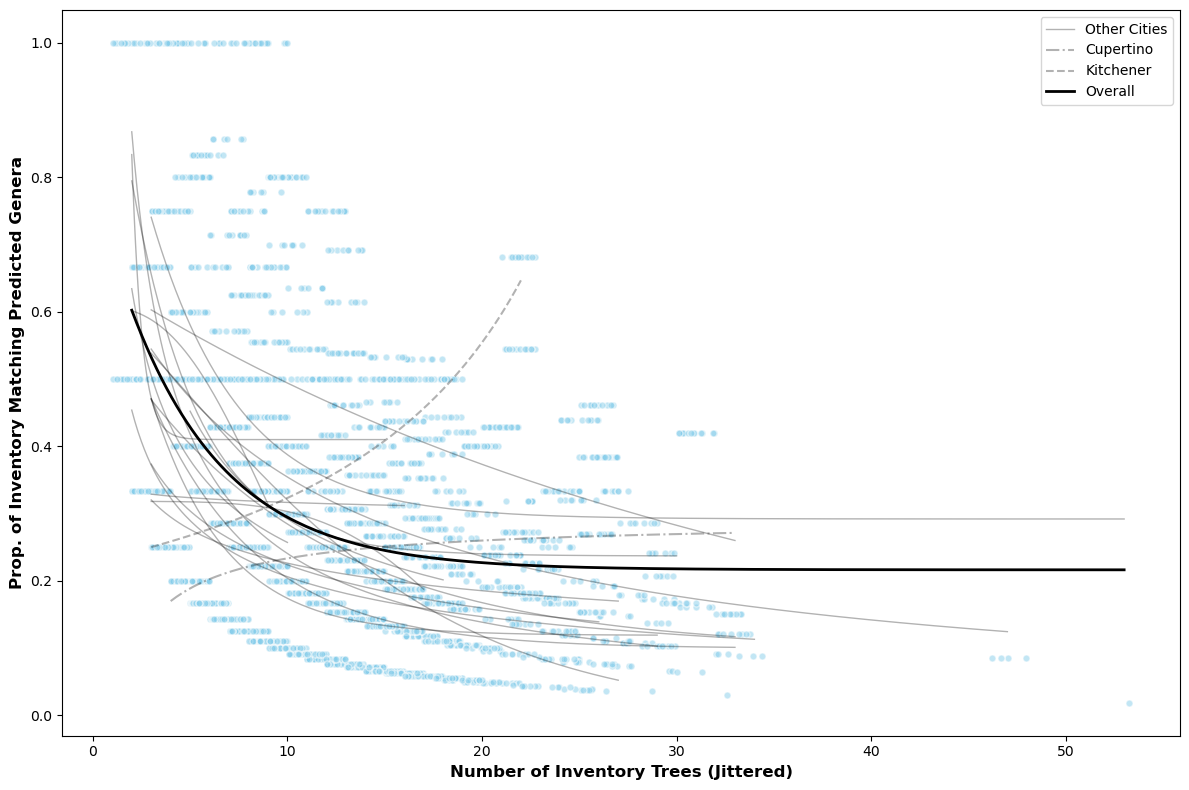

In [45]:
plt.figure(figsize=(12, 8))

# Add jitter to the data
df['jittered_x'] = df['num_inv_trees'] + np.random.uniform(-1, 1, size=len(df))


# Plot best fit for each city with specific styles for Kitchener and Cupertino (formerly Sioux Falls)
for city, group in grouped:
    # Retrieve the best fit for the city
    best_fit_city = next(
        (result for result in best_results_list if result['City'] == city and result['Scope'] == 'City'), 
        None
    )
    if best_fit_city:
        best_func = [func for func, label in functions if label == best_fit_city['Function']][0]
        x_fit_city = np.linspace(group['num_inv_trees'].min(), group['num_inv_trees'].max(), 200)
        y_fit_city = best_func(x_fit_city, *best_fit_city['Parameters'])
        
        # Style based on city
        if city == "Kitchener":
            plt.plot(
                x_fit_city, 
                y_fit_city, 
                linestyle='--', 
                color='black',
                alpha=0.3, 
                linewidth=1.5, 
                label="Kitchener" if city == "Kitchener" else None,
                zorder=2
            )
        elif city == "Cupertino":
            plt.plot(
                x_fit_city, 
                y_fit_city, 
                linestyle='-.', 
                color='black',
                alpha=0.3, 
                linewidth=1.5, 
                label="Cupertino" if city == "Cupertino" else None,
                zorder=2
            )
        else:
            plt.plot(
                x_fit_city, 
                y_fit_city, 
                linestyle='-', 
                color='black', 
                alpha=0.3, 
                linewidth=1, 
                label=None if city != list(grouped.groups.keys())[0] else "Other Cities",
                zorder=2
            )

# Plot the overall best fit
best_func_overall = [func for func, label in functions if label == best_overall_fit[0]][0]
y_fit_overall = best_func_overall(x_fit_overall, *best_overall_fit[2])

plt.plot(
    x_fit_overall, 
    y_fit_overall, 
    color='black', 
    linewidth=2, 
    label="Overall",
    zorder=3
)

# Scatter plot for raw data with white outline around points
plt.scatter(
    df['jittered_x'], 
    df['proportion_matches'], 
    color='skyblue', 
    edgecolors='white', 
    alpha=0.5, 
    s=25, 
    zorder=1  # Scatter points are behind the trend lines
)

# Customize the plot
plt.xlabel("Number of Inventory Trees (Jittered)", fontsize=12, fontweight='bold')
plt.ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=12, fontweight='bold')

# Add legend without "Fit Lines" title
plt.legend(loc="upper right", fontsize=10, frameon=True, title=None)

plt.tight_layout()

# Save and show the plot
output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/all_cities_per_city_prop_matches_num_inv_trees_w_trendlines.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')
plt.show()

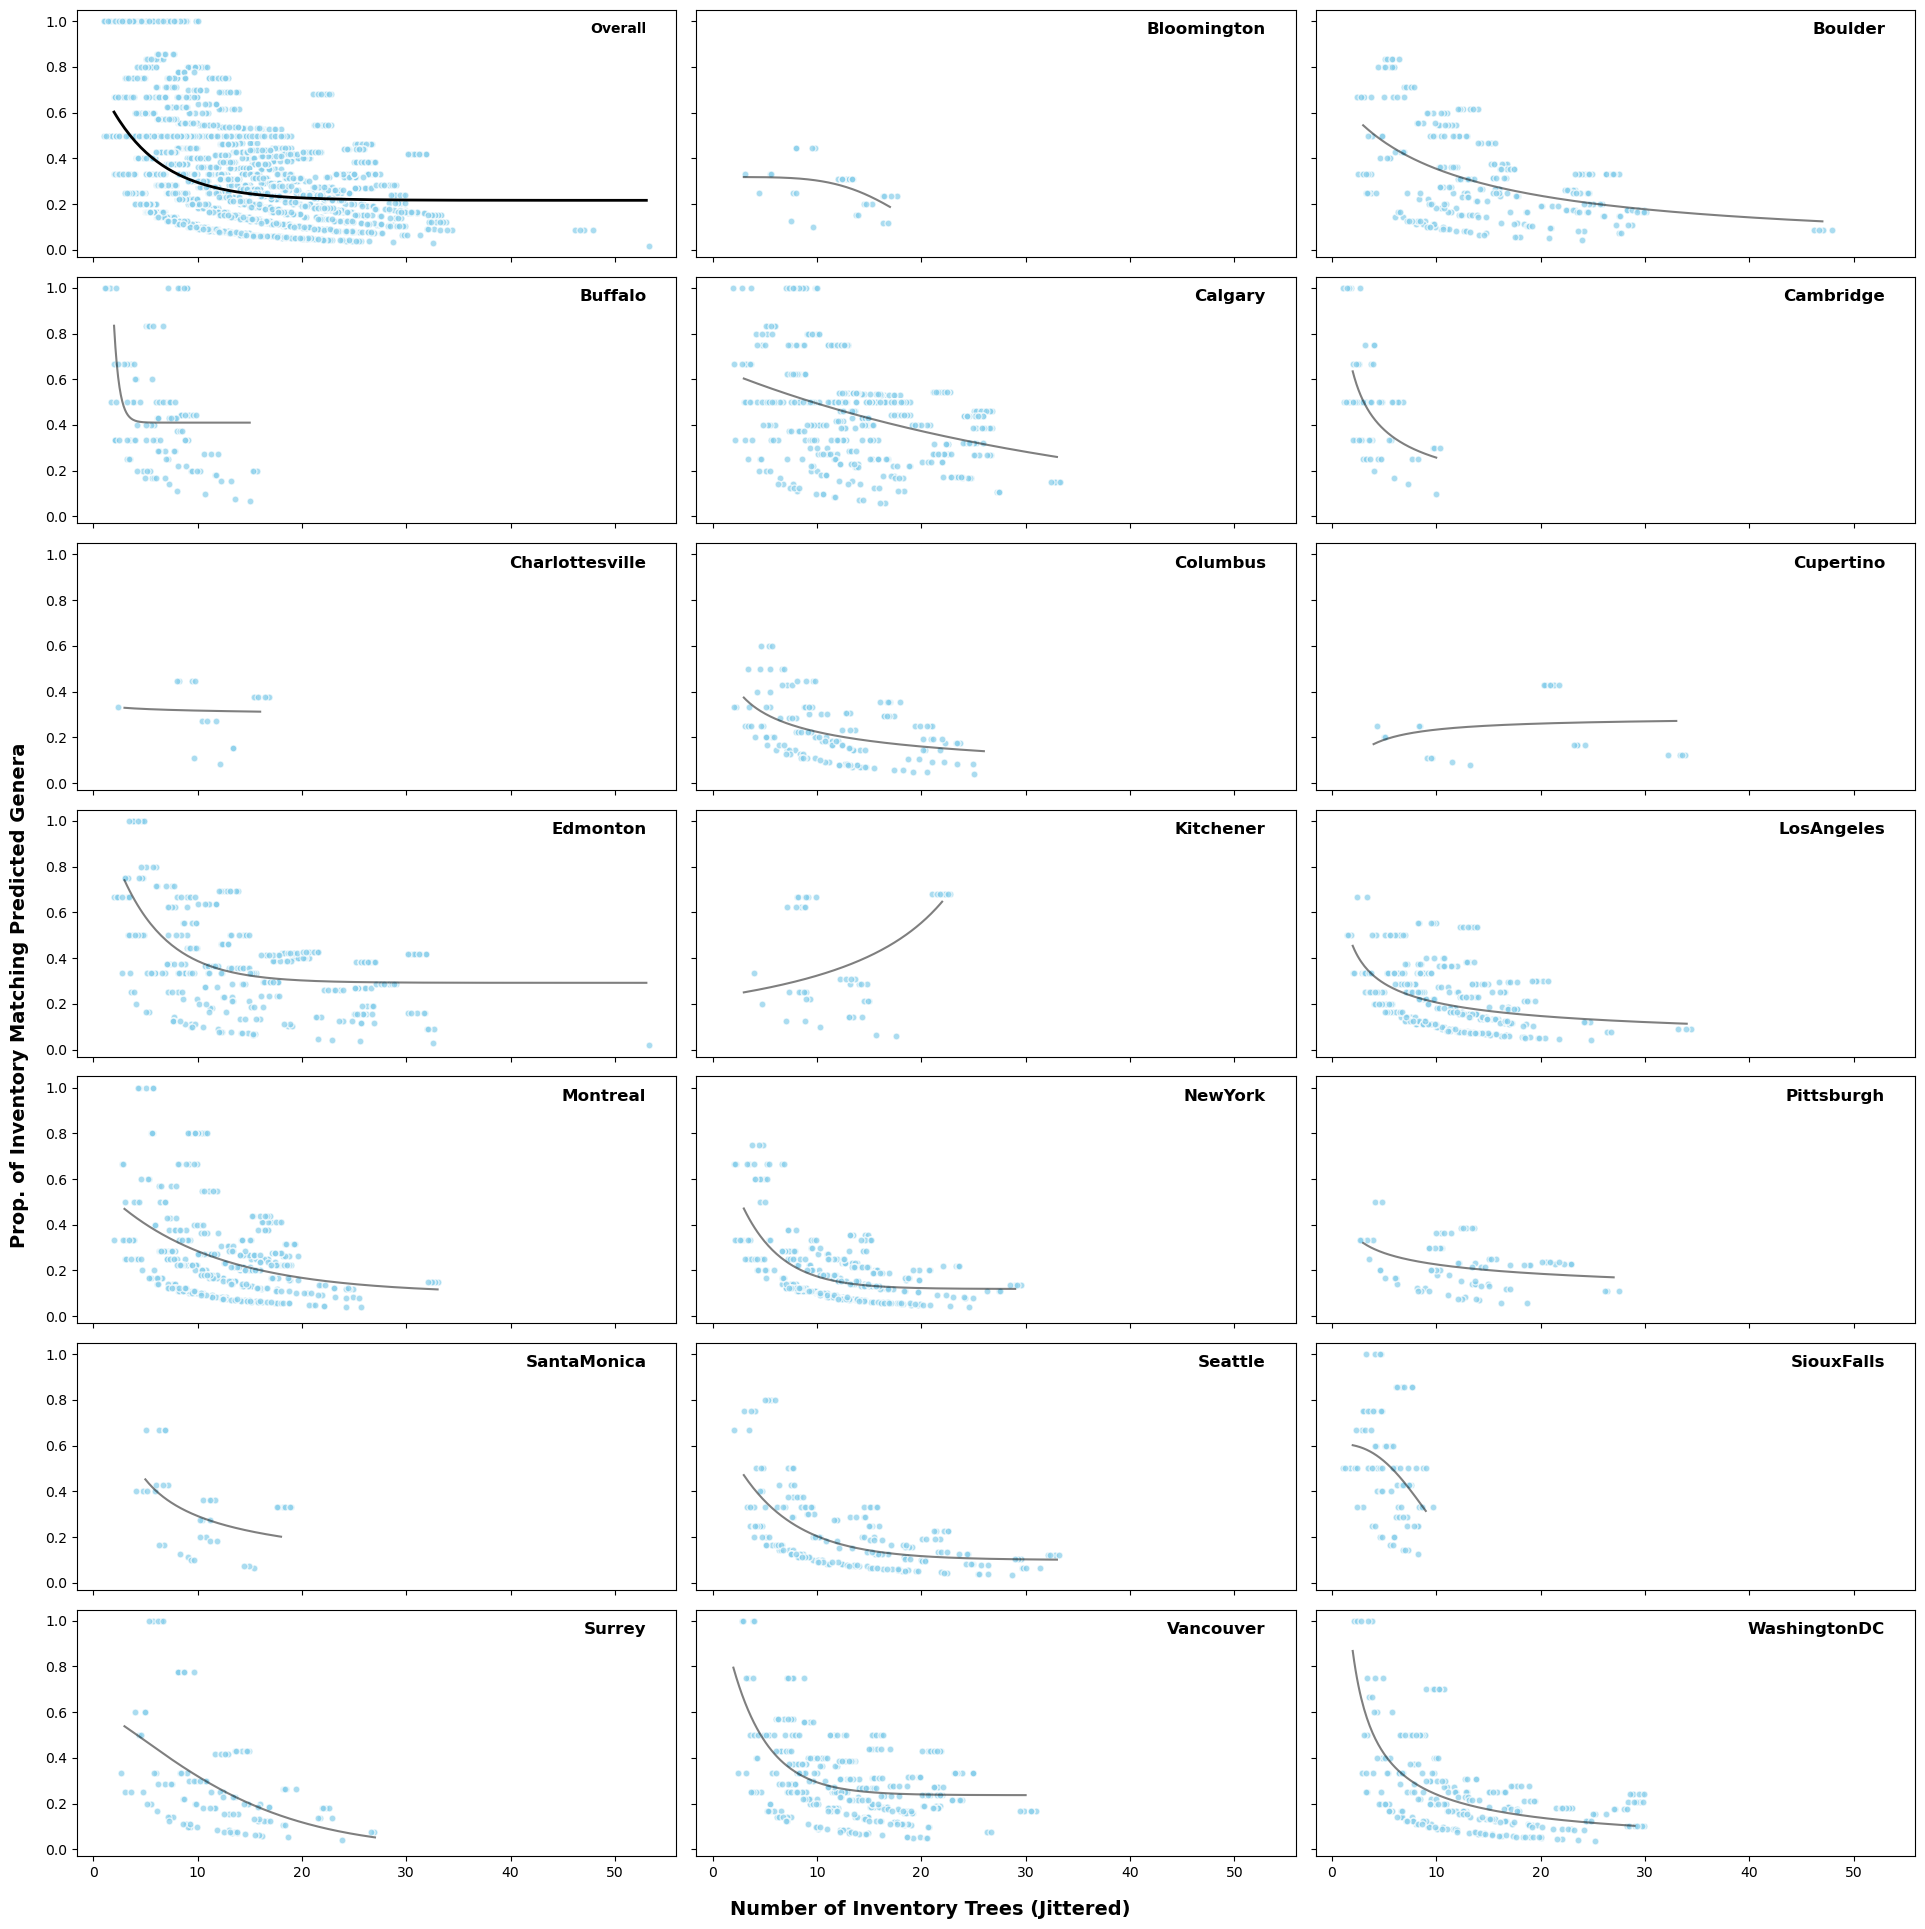

In [46]:
# Determine the number of required subplots based on data
total_plots = len(grouped) + 1  # Adding 1 for the overall plot
rows = (total_plots // 3) + (1 if total_plots % 3 != 0 else 0)

# Create figure and subplots
fig, axes = plt.subplots(rows, 3, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot overall in the first subplot
ax = axes[0]
ax.plot(x_fit_overall, y_fit_overall, color='black', linewidth=2, label="Overall", zorder=3)
ax.scatter(
    df['jittered_x'], 
    df['proportion_matches'], 
    color='skyblue', 
    edgecolors='white', 
    alpha=0.7, 
    s=25, 
    zorder=1
)
ax.text(0.95, 0.95, "Overall", fontsize=10, fontweight="bold", transform=ax.transAxes, ha="right", va="top")

# Plot each city in alphabetical order
for i, (city, group) in enumerate(sorted(grouped, key=lambda x: x[0]), start=1):
    ax = axes[i]

    # Retrieve the best fit for the city
    best_fit_city = next(
        (result for result in best_results_list if result['City'] == city and result['Scope'] == 'City'), 
        None
    )
    if best_fit_city:
        best_func = [func for func, label in functions if label == best_fit_city['Function']][0]
        x_fit_city = np.linspace(group['num_inv_trees'].min(), group['num_inv_trees'].max(), 200)
        y_fit_city = best_func(x_fit_city, *best_fit_city['Parameters'])

        # Style based on city
        ax.plot(
            x_fit_city, 
            y_fit_city, 
            linestyle='-', 
            color='black', 
            alpha=0.5, 
            linewidth=1.5,
            zorder=2
        )

    # Scatter plot for the city
    ax.scatter(
        group['jittered_x'], 
        group['proportion_matches'], 
        color='skyblue', 
        edgecolors='white', 
        alpha=0.7, 
        s=25, 
        zorder=1
    )
    ax.text(0.95, 0.95, city, fontsize=12, fontweight="bold", transform=ax.transAxes, ha="right", va="top")

# Hide any unused subplots
for j in range(total_plots, len(axes)):
    fig.delaxes(axes[j])

# Add shared x and y axis labels
fig.text(0.5, 0.04, 'Number of Inventory Trees (Jittered)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Prop. of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

# Save and show
output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/all_cities_per_city_prop_matches_num_inv_trees_w_trendlines_facet.png'
plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")
plt.show()

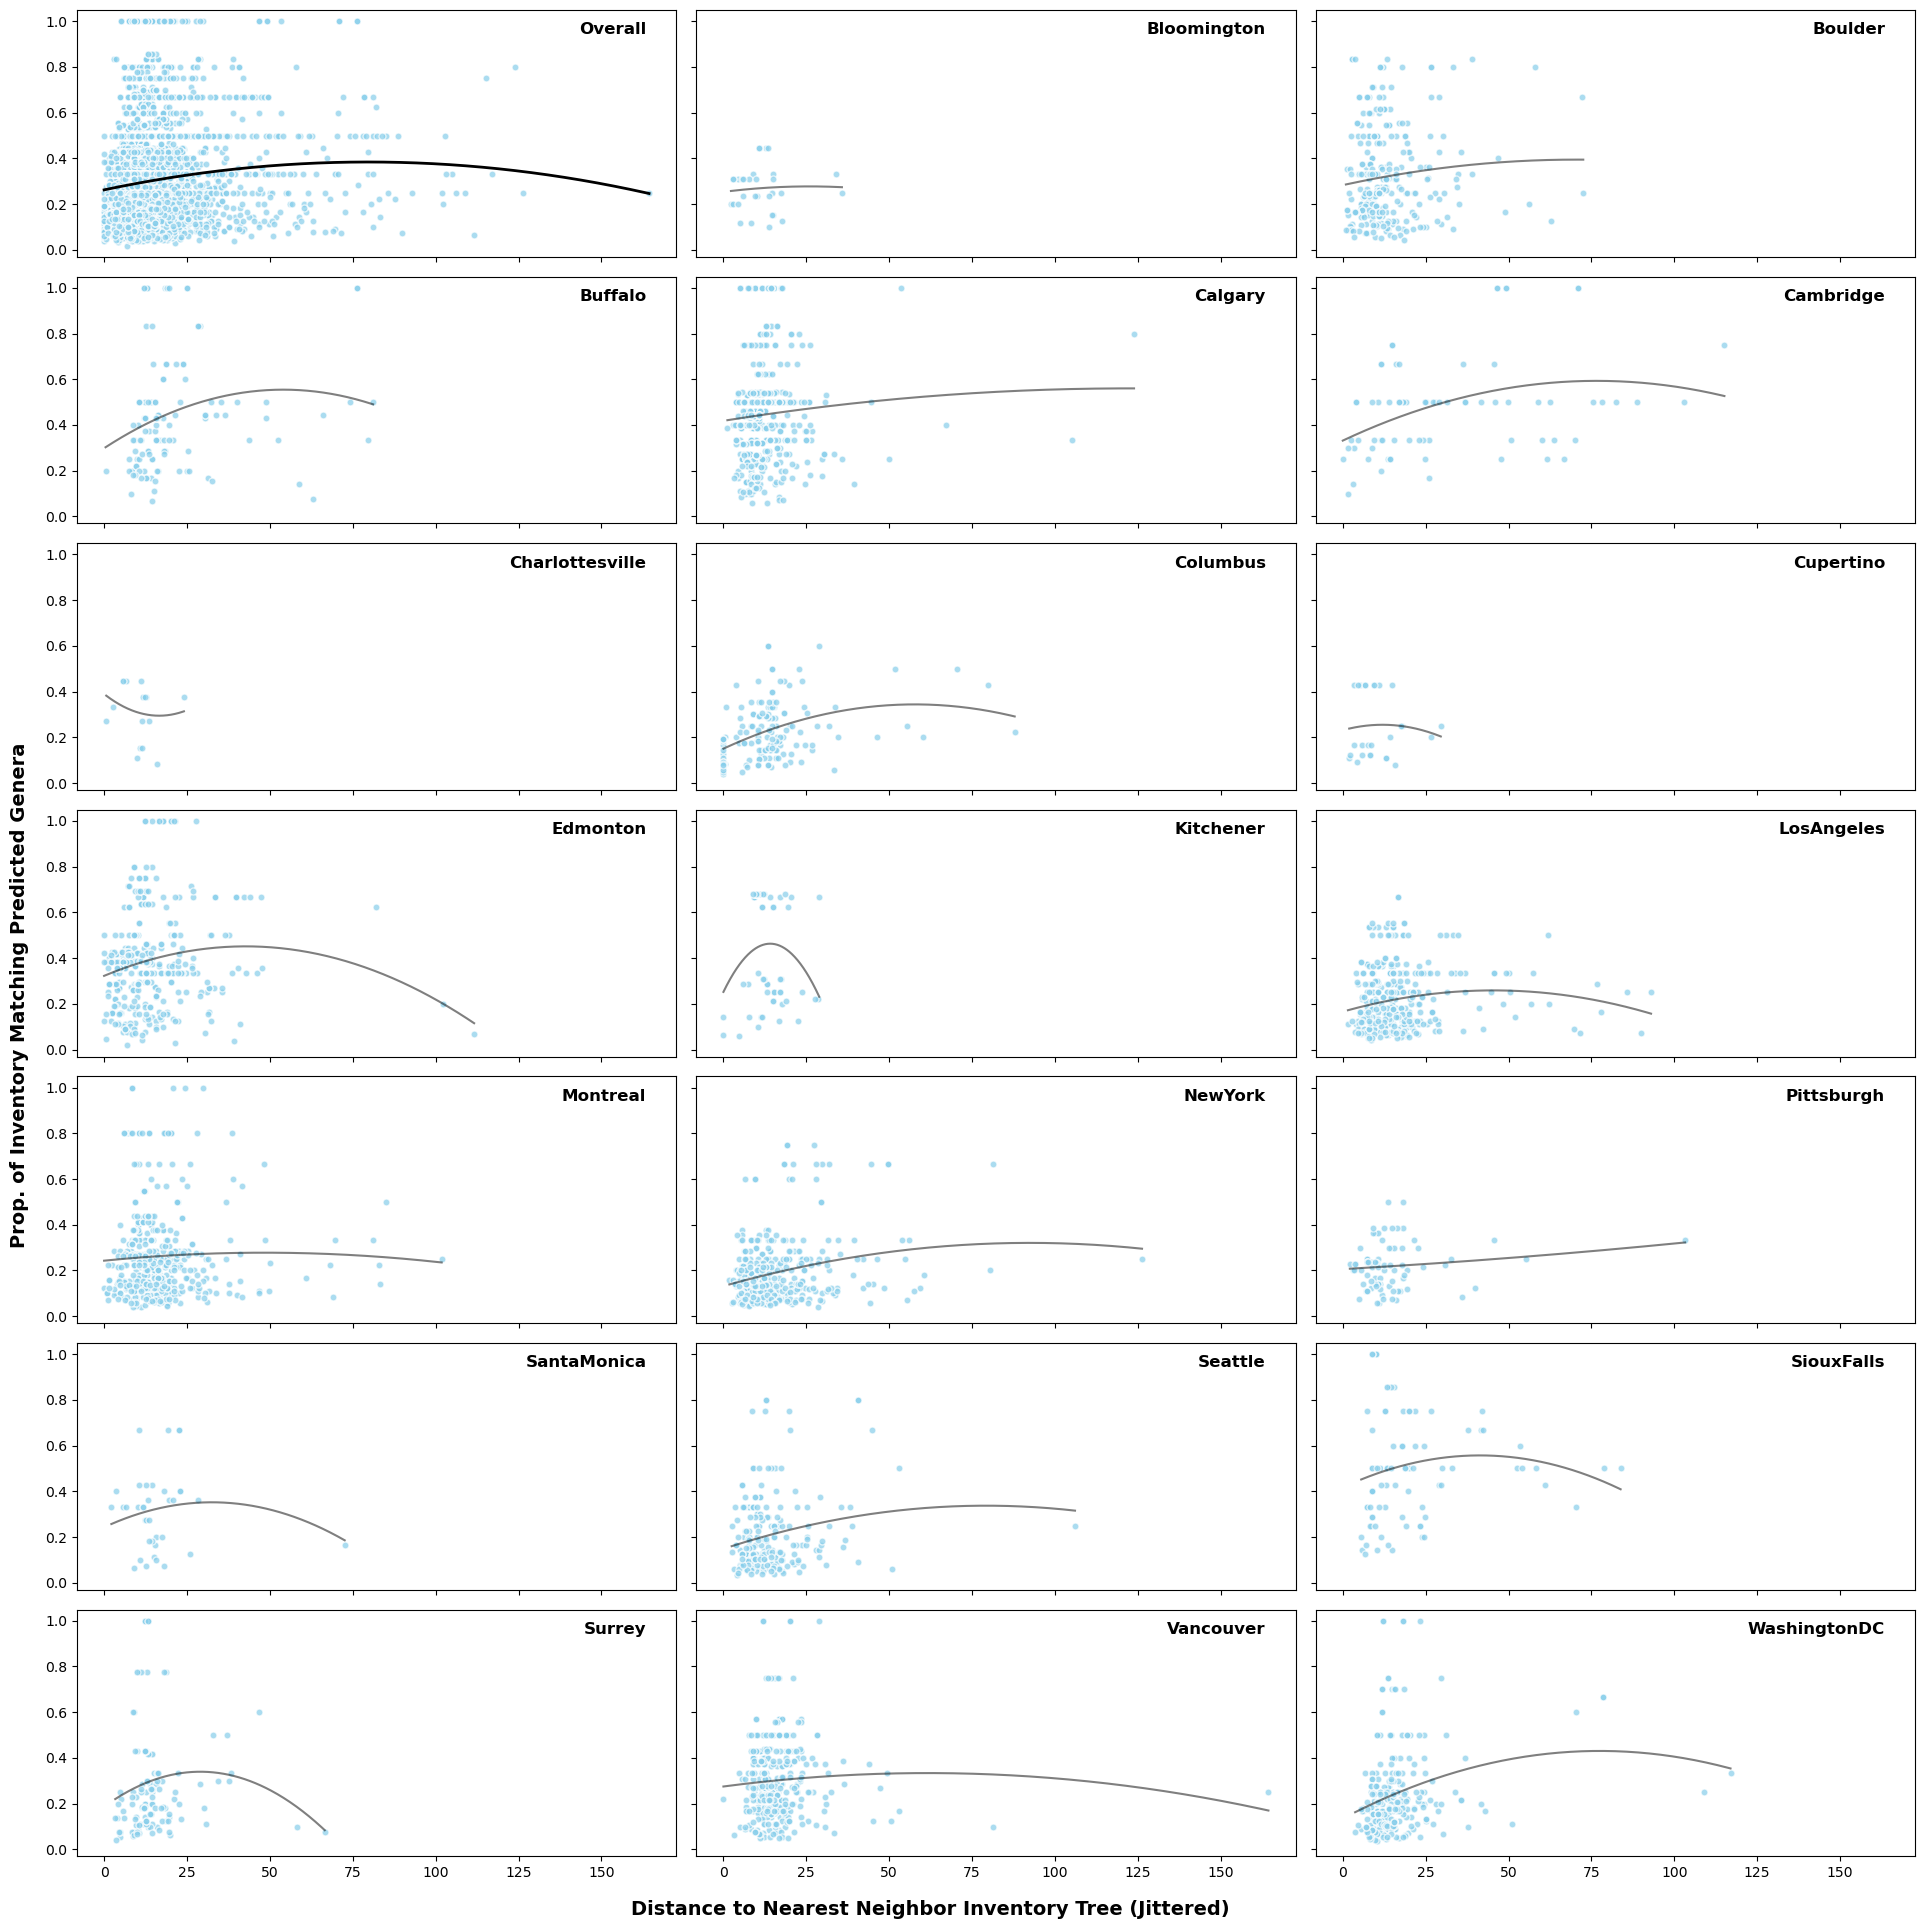

In [51]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

# Define linear and polynomial functions
def linear_func(x, m, c):
  return m * x + c

def poly_func(x, a, b, c):
  return a * x**2 + b * x + c

# Fit models and calculate RMSE
def fit_and_evaluate(x, y):
  # Fit linear model
  popt_linear, _ = curve_fit(linear_func, x, y)
  y_pred_linear = linear_func(x, *popt_linear)
  rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
  
  # Fit polynomial model
  popt_poly, _ = curve_fit(poly_func, x, y)
  y_pred_poly = poly_func(x, *popt_poly)
  rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
  
  return (popt_linear, rmse_linear), (popt_poly, rmse_poly)

# Fit and evaluate models for overall data
overall_linear, overall_poly = fit_and_evaluate(df['min_nn_distance'], df['proportion_matches'])

# Determine the best overall fit
best_overall_fit = overall_linear if overall_linear[1] < overall_poly[1] else overall_poly
best_overall_func = linear_func if overall_linear[1] < overall_poly[1] else poly_func

# Fit and evaluate models for each city
city_fits = {}
for city, group in df.groupby('All_Cities'):
  linear_fit, poly_fit = fit_and_evaluate(group['min_nn_distance'], group['proportion_matches'])
  best_fit = linear_fit if linear_fit[1] < poly_fit[1] else poly_fit
  city_fits[city] = best_fit

# Plot overall and per city subplots with best fit trendline
total_plots = len(city_fits) + 1
rows = (total_plots // 3) + (1 if total_plots % 3 != 0 else 0)

fig, axes = plt.subplots(rows, 3, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot overall in the first subplot
x_fit_overall = np.linspace(df['min_nn_distance'].min(), df['min_nn_distance'].max(), 200)
y_fit_overall = best_overall_func(x_fit_overall, *best_overall_fit[0])

axes[0].plot(x_fit_overall, y_fit_overall, color='black', linewidth=2, label="Overall")
axes[0].scatter(df['min_nn_distance'], df['proportion_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
axes[0].text(0.95, 0.95, "Overall", fontsize=12, fontweight="bold", transform=axes[0].transAxes, ha="right", va="top")

# Plot each city
for i, (city, group) in enumerate(df.groupby('All_Cities'), start=1):
  x_fit_city = np.linspace(group['min_nn_distance'].min(), group['min_nn_distance'].max(), 200)
  best_fit_func = linear_func if city_fits[city][1] < city_fits[city][1] else poly_func
  y_fit_city = best_fit_func(x_fit_city, *city_fits[city][0])
  axes[i].scatter(group['min_nn_distance'], group['proportion_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
  axes[i].plot(x_fit_city, y_fit_city, color='black', linewidth=1.5, alpha=0.5)
  axes[i].text(0.95, 0.95, city, fontsize=12, fontweight="bold", transform=axes[i].transAxes, ha="right", va="top")

# Hide unused subplots
for j in range(total_plots, len(axes)):
  fig.delaxes(axes[j])

# Add shared x and y axis labels
fig.text(0.5, 0.04, 'Distance to Nearest Neighbor Inventory Tree (Jittered)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Prop. of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

# Save and show the plot
#output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/all_cities_facet_plot_prop_matches_min_nn_distance.png'
#plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")
plt.show()

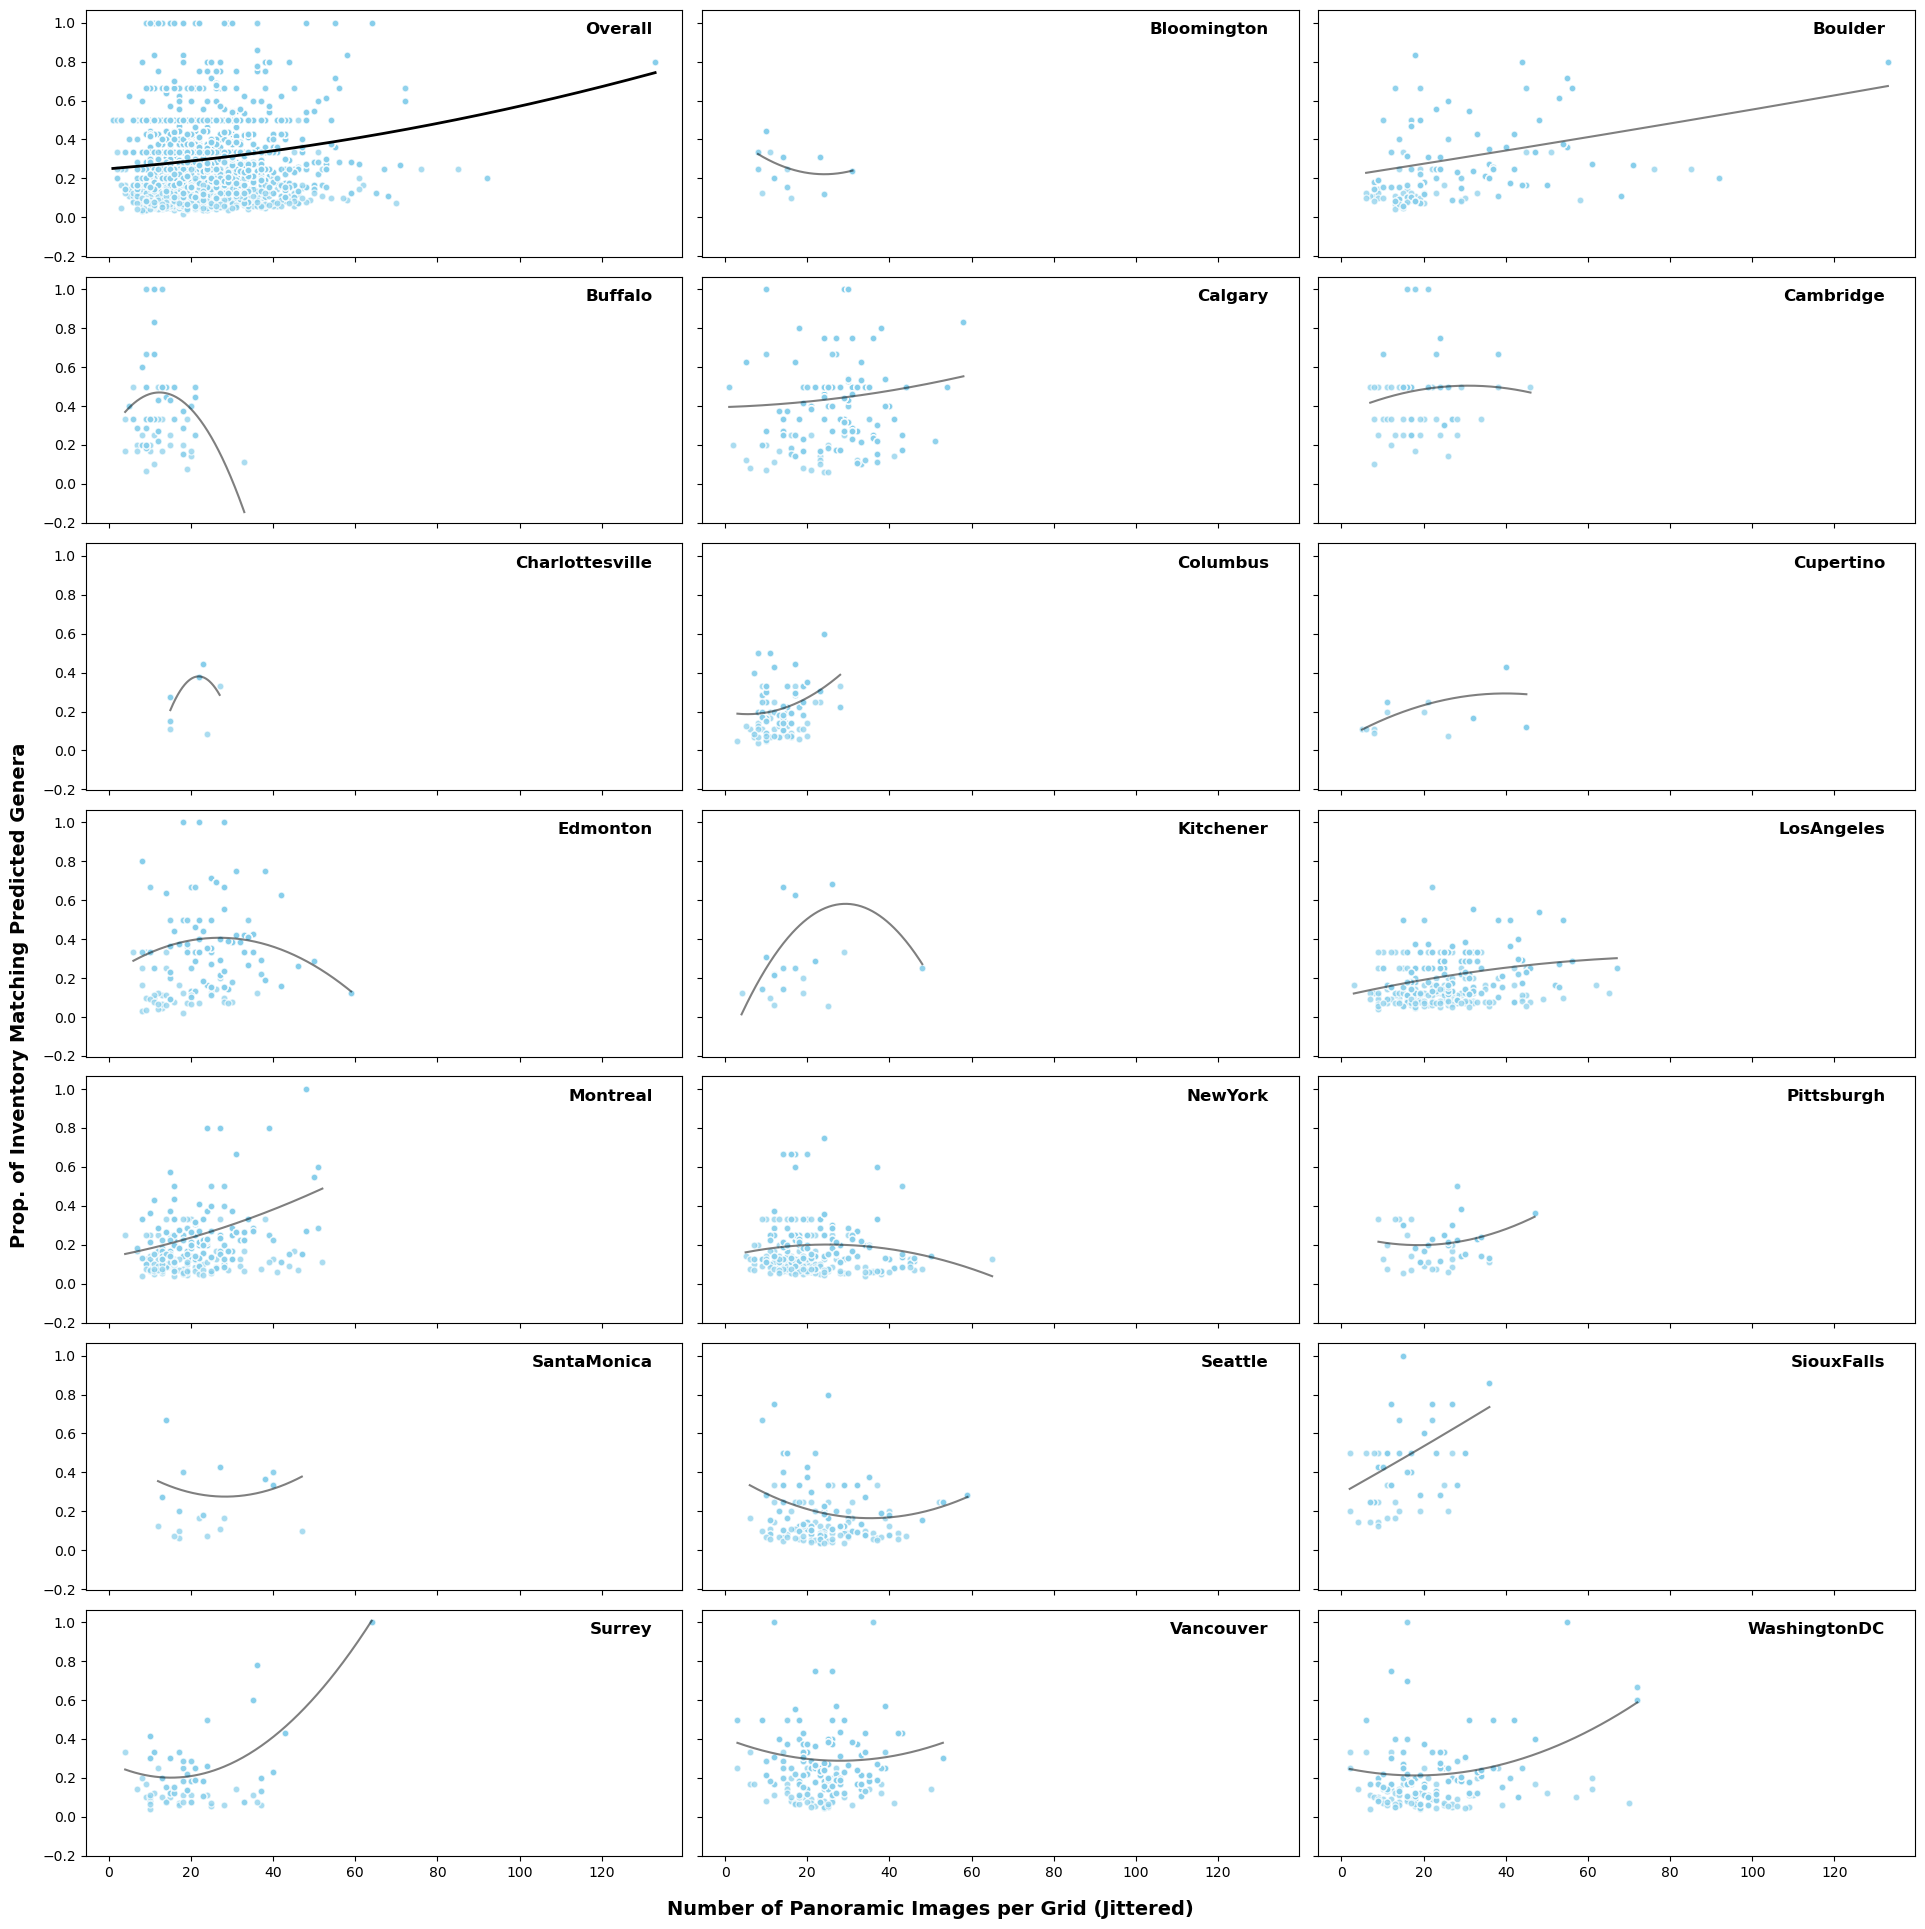

In [50]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

# Define linear and polynomial functions
def linear_func(x, m, c):
    return m * x + c

def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit models and calculate RMSE
def fit_and_evaluate(x, y):
    # Fit linear model
    popt_linear, _ = curve_fit(linear_func, x, y)
    y_pred_linear = linear_func(x, *popt_linear)
    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
    
    # Fit polynomial model
    popt_poly, _ = curve_fit(poly_func, x, y)
    y_pred_poly = poly_func(x, *popt_poly)
    rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
    
    return (popt_linear, rmse_linear), (popt_poly, rmse_poly)

# Fit and evaluate models for overall data
overall_linear, overall_poly = fit_and_evaluate(df['grid_num_panos'], df['proportion_matches'])

# Determine the best overall fit
best_overall_fit = overall_linear if overall_linear[1] < overall_poly[1] else overall_poly
best_overall_func = linear_func if overall_linear[1] < overall_poly[1] else poly_func

# Fit and evaluate models for each city
city_fits = {}
for city, group in df.groupby('All_Cities'):
    linear_fit, poly_fit = fit_and_evaluate(group['grid_num_panos'], group['proportion_matches'])
    best_fit = linear_fit if linear_fit[1] < poly_fit[1] else poly_fit
    city_fits[city] = best_fit

# Plot overall and per city subplots with best fit trendline
total_plots = len(city_fits) + 1
rows = (total_plots // 3) + (1 if total_plots % 3 != 0 else 0)

fig, axes = plt.subplots(rows, 3, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot overall in the first subplot
x_fit_overall = np.linspace(df['grid_num_panos'].min(), df['grid_num_panos'].max(), 200)
y_fit_overall = best_overall_func(x_fit_overall, *best_overall_fit[0])

axes[0].plot(x_fit_overall, y_fit_overall, color='black', linewidth=2, label="Overall")
axes[0].scatter(df['grid_num_panos'], df['proportion_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
axes[0].text(0.95, 0.95, "Overall", fontsize=12, fontweight="bold", transform=axes[0].transAxes, ha="right", va="top")

# Plot each city
for i, (city, group) in enumerate(df.groupby('All_Cities'), start=1):
    x_fit_city = np.linspace(group['grid_num_panos'].min(), group['grid_num_panos'].max(), 200)
    best_fit_func = linear_func if city_fits[city][1] < city_fits[city][1] else poly_func
    y_fit_city = best_fit_func(x_fit_city, *city_fits[city][0])
    axes[i].scatter(group['grid_num_panos'], group['proportion_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
    axes[i].plot(x_fit_city, y_fit_city, color='black', linewidth=1.5, alpha=0.5)
    axes[i].text(0.95, 0.95, city, fontsize=12, fontweight="bold", transform=axes[i].transAxes, ha="right", va="top")

# Hide unused subplots
for j in range(total_plots, len(axes)):
    fig.delaxes(axes[j])

# Add shared x and y axis labels
fig.text(0.5, 0.04, 'Number of Panoramic Images per Grid (Jittered)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Prop. of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

# Save and show the plot
#output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures_100genera/all_cities_facet_plot_prop_matches_grid_num_panos.png'
#plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")
plt.show()